In [1]:
import numpy as np
import scipy.stats as sps
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
#Global Variables
WAD = 10**18
RAY = 10**27
RAD = 10**45
SPY = 31536000 # seconds per year
MAX = 2**255
SPH = 60*60

In [3]:
#assume
halflife=SPY/52 #weeklong halflife
alpha = int(np.power(.5,float(1/halflife))*RAY)

In [4]:
params = {
    'expected_lag': [10],
    'minimum_period': [SPH],
    'correction_wt': [0.5],
    'noise_wt': [0.001],
    'alpha': [alpha] #in 1/RAY
}

params

{'expected_lag': [10],
 'minimum_period': [3600],
 'correction_wt': [0.5],
 'noise_wt': [0.001],
 'alpha': [999998857063901981428416512]}

In [5]:
state = {
    'price': int(RAY), #in 1/RAY
    'target': int(RAY), #in 1/RAY
    'error': {'new':0, 'old':0}, #in 1/RAY
    'leaky_integral': 0, #in 1/RAY * seconds (?)
    'integral': 0,  
    'Dt': 0, #seconds
    'timestamp': dt.datetime.now() #date
}

state

{'price': 1000000000000000000000000000,
 'target': 1000000000000000000000000000,
 'error': {'new': 0, 'old': 0},
 'leaky_integral': 0,
 'integral': 0,
 'Dt': 0,
 'timestamp': datetime.datetime(2020, 8, 31, 11, 59, 49, 951321)}

In [6]:
def event(params, step, sL, s):

    error =s['price']-s['target']
    delta_time = sps.expon.rvs(loc = params['minimum_period'], scale = params['expected_lag'])

    return({'error':error, 'delta_time': delta_time})

def time_move(params, step, sL, s, _input):

    seconds = _input['delta_time']
    td = dt.timedelta(days=0, seconds=seconds)
    key = 'timestamp'
    value = s['timestamp']+td

    return(key, value)

def store_Dt(params, step, sL, s, _input):

    key = 'Dt'
    value = np.floor(_input['delta_time'])

    return(key, value)

def store_error(params, step, sL, s, _input):

    key = 'error'

    new_error = _input['error']
    old_error = s['error']['new']

    value = {'new':new_error, 'old':old_error}

    return(key, value)

def update_integral(params, step, sL, s, _input):
    """
    Given integral previous value I, and the last two errors [new_error, old_error] and time pased Dt
        A = Dt*(new_error+old_error)/2
        I = I + A  
    """

    new_error = s['error']['new']
    old_error = s['error']['old']

    e_bar = int((new_error+old_error)/2)

    Dt = s['Dt']

    area = e_bar*Dt

    value = s['integral']+area
    key = 'integral'

    return(key, value)

def update_leaky_integral(params, step, sL, s, _input):
    """
    Given integral previous value I, and the last two errors [new_error, old_error] and time pased Dt
        A = Dt*(new_error+old_error)/2
        I = alpha^Dt *I + A  
    """

    new_error = s['error']['new']
    old_error = s['error']['old']

    e_bar = int((new_error+old_error)/2)

    Dt = s['Dt']

    area = e_bar*Dt

    alpha = params['alpha']
    remaing_frac = float(alpha/RAY)**Dt

    remaining = int(remaing_frac*s['leaky_integral'])

    value = remaining+area
    key = 'leaky_integral'

    return(key, value)

def martingale(params, step, sL, s):

    theta = params['correction_wt']
    noise = np.random.randn()*params['noise_wt']
    raw_price = float(s['price'])/RAY
    raw_target = float(s['target'])/RAY

    raw_price = theta*raw_target+(1-theta)*raw_price + noise
    
    return({'raw_price':raw_price})

def price_move(params, step, sL, s, _input):

    raw_price = _input['raw_price']
    price = int(raw_price*RAY)

    key = 'price'
    value = price

    return(key, value)

In [7]:
PSUBs = [
    {
        'policies': {
            'update_event': event
        },
        'variables': {
            'error': store_error,
            'timestamp':time_move,
            'Dt': store_Dt
        }
    },
    {
        'policies': {},
        'variables': {
            'leaky_integral': update_leaky_integral,
            'integral': update_integral,
        }
    },
    {
        'policies': {
            'martingale': martingale        },
        'variables': {
            'price': price_move,
        }
    },
]

In [8]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim

sim_config = config_sim (
    {
        'T': range(100),
        'N': 3,
        'M': params
    }
)

In [9]:

exp = Experiment()

exp.append_configs(
    sim_configs=sim_config,
    initial_state=state,
    partial_state_update_blocks=PSUBs
)

from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context, configs)
raw_result, tensor, _ = executor.execute()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 5, 3, 7)
Execution Method: local_simulations
SimIDs   : [0, 0, 0]
SubsetIDs: [0, 0, 0]
Ns       : [0, 1, 2]
ExpIDs   : [0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.26s


In [10]:
df = pd.DataFrame(raw_result)

In [11]:
rdf = df[df.run==1]
rdf = rdf[rdf.substep<=1]
#rdf = rdf.drop_duplicates(subset=['simulation','run', 'substep', 'timestep'])

In [12]:
rdf.tail()

,price,target,error,leaky_integral,integral,Dt,timestamp,simulation,subset,run,substep,timestep
286,1001110746026384886123724800,1000000000000000000000000000,"{'new': 1110746026384886123724800, 'old': 9029...",1.194826e+29,1.317063e+29,3608.0,2020-09-04 12:16:47.682186,0,0,1,1,96
289,999124521308298495834193920,1000000000000000000000000000,"{'new': -875478691701504165806080, 'old': 1110...",1.226236e+29,1.353390e+29,3617.0,2020-09-04 13:17:05.326629,0,0,1,1,97
292,1000289108163899629164822528,1000000000000000000000000000,"{'new': 289108163899629164822528, 'old': -8754...",1.225432e+29,1.357645e+29,3605.0,2020-09-04 14:17:10.649500,0,0,1,1,98
295,1000073407419478217957834752,1000000000000000000000000000,"{'new': 73407419478217957834752, 'old': 289108...",1.209824e+29,1.347076e+29,3621.0,2020-09-04 15:17:32.499346,0,0,1,1,99
298,998988720372200286921424896,1000000000000000000000000000,"{'new': -1011279627799713078575104, 'old': 734...",1.211390e+29,1.353639e+29,3610.0,2020-09-04 16:17:43.209813,0,0,1,1,100


In [13]:
rdf['normed_integral'] = rdf.integral.apply(lambda x: x/(RAY*SPH))
rdf['normed_leaky_integral'] = rdf.leaky_integral.apply(lambda x: x/(RAY*SPH)) #note the conversion of unint on the integral to be PER HOUR using SPH
rdf['normed_price'] = rdf.price.apply(lambda x: x/RAY)
rdf['normed_target'] = rdf.target.apply(lambda x: x/RAY)
rdf['normed_error']  = rdf.normed_price-rdf.normed_target

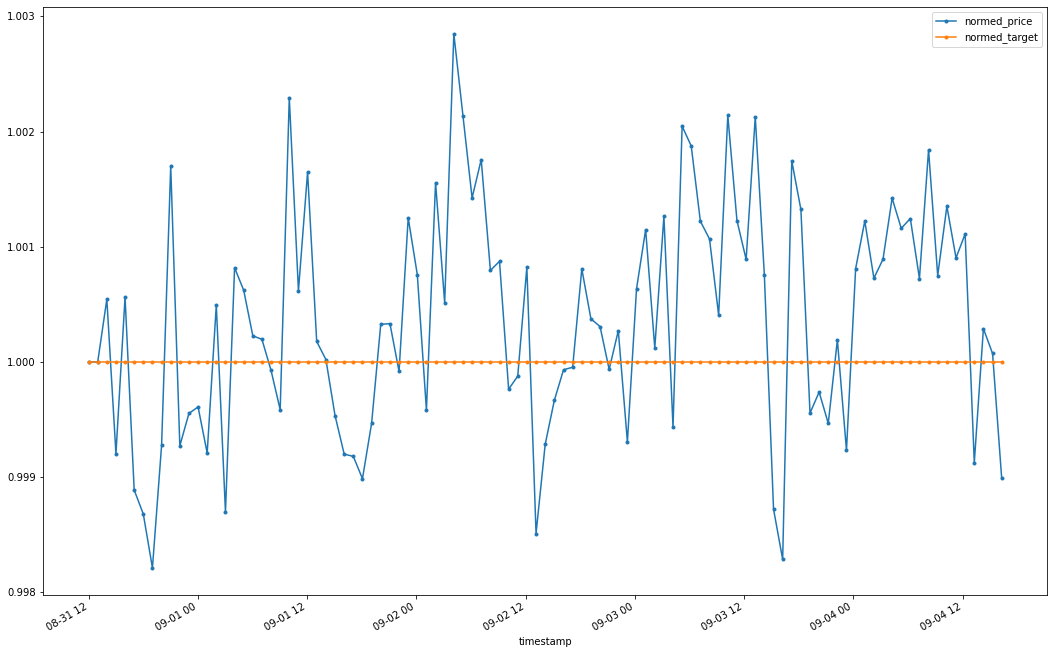

In [14]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['normed_price','normed_target'], marker='.', ax=plt.gca())

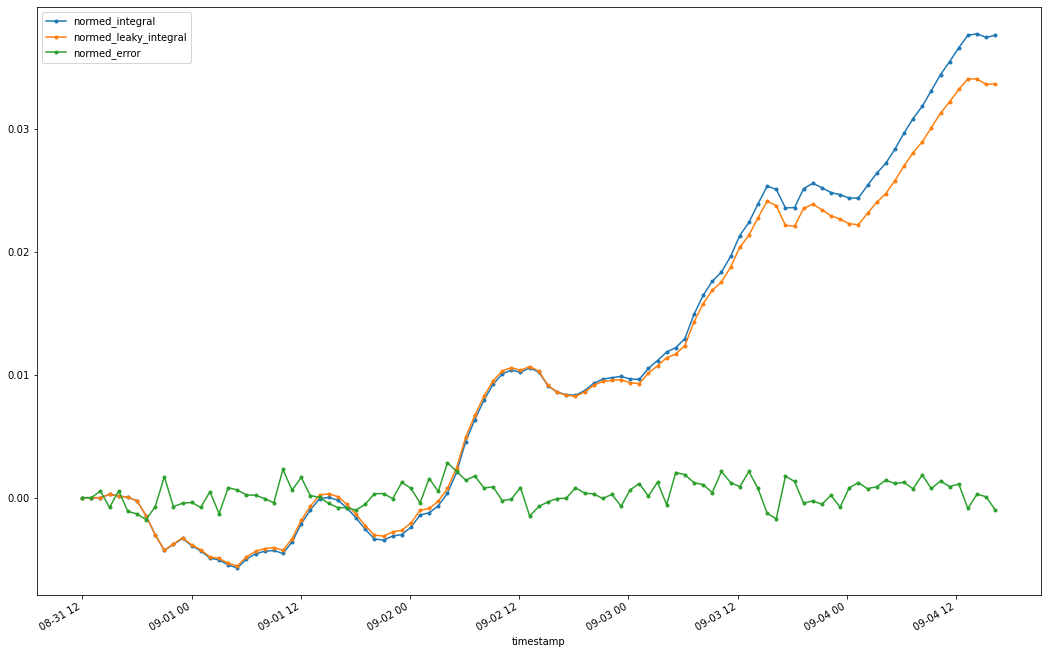

In [15]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['normed_integral', 'normed_leaky_integral','normed_error'], marker='.', ax=plt.gca())

In [16]:
rdf['new_error'] = rdf.error.apply(lambda x: x['new'])
rdf['old_error'] = rdf.error.apply(lambda x: ['old'])

rdf['cast_new_error'] = rdf.error.apply(lambda x: float(x['new']))
rdf['cast_old_error'] = rdf.error.apply(lambda x: float(x['old']))

rdf['normed_new_error'] = rdf.error.apply(lambda x: float(x['new']/RAY))
rdf['normed_old_error'] = rdf.error.apply(lambda x: float(x['old']/RAY))

rdf['mean_error'] = rdf.error.apply(lambda x: int((x['new']+x['old'])/2))
rdf['cast_mean_error'] = rdf.mean_error.apply(float)
rdf['normed_mean_error'] = rdf.cast_mean_error.apply(lambda x: float(x/RAY))

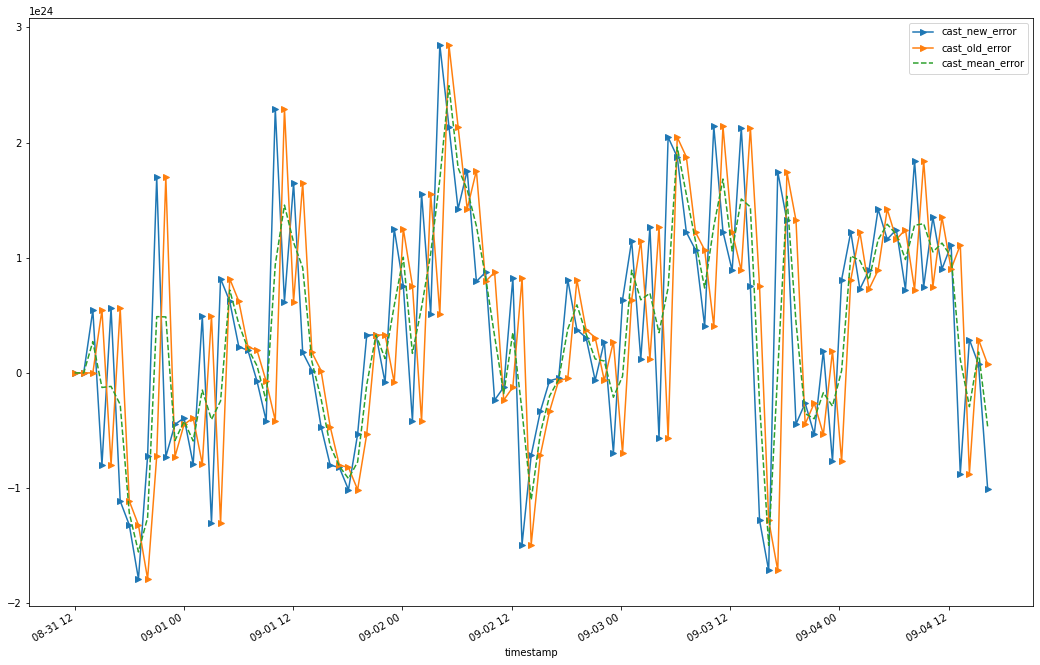

In [17]:
plt.figure(figsize=(18, 12))
rdf[['cast_new_error','cast_old_error','timestamp']].plot(x='timestamp', marker='>', ax=plt.gca())
rdf[['cast_mean_error','timestamp']].plot(x='timestamp', marker=None, linestyle='--', ax=plt.gca())

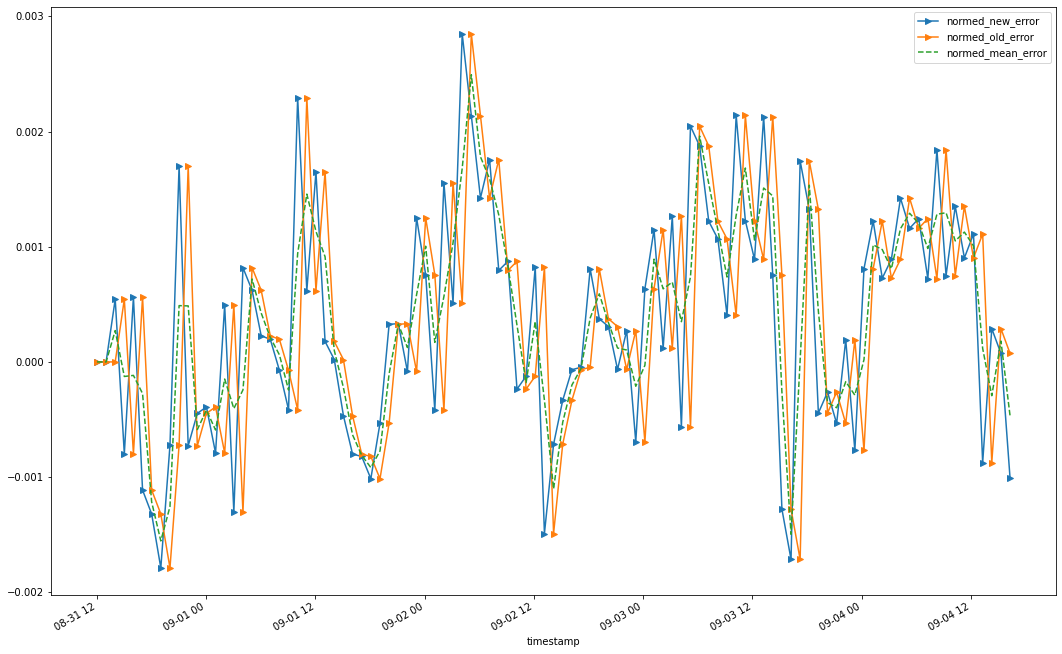

In [18]:
plt.figure(figsize=(18, 12))
rdf[['normed_new_error','normed_old_error','timestamp']].plot(x='timestamp', marker='>', ax=plt.gca())
rdf[['normed_mean_error','timestamp']].plot(x='timestamp', marker=None, linestyle='--', ax=plt.gca())

In [19]:
rdf['cast_integral'] = rdf.integral.apply(float)
rdf['cast_leaky_integral'] = rdf.leaky_integral.apply(float)
rdf['cast_price'] = rdf.price.apply(float)
rdf['cast_target'] = rdf.target.apply(float)

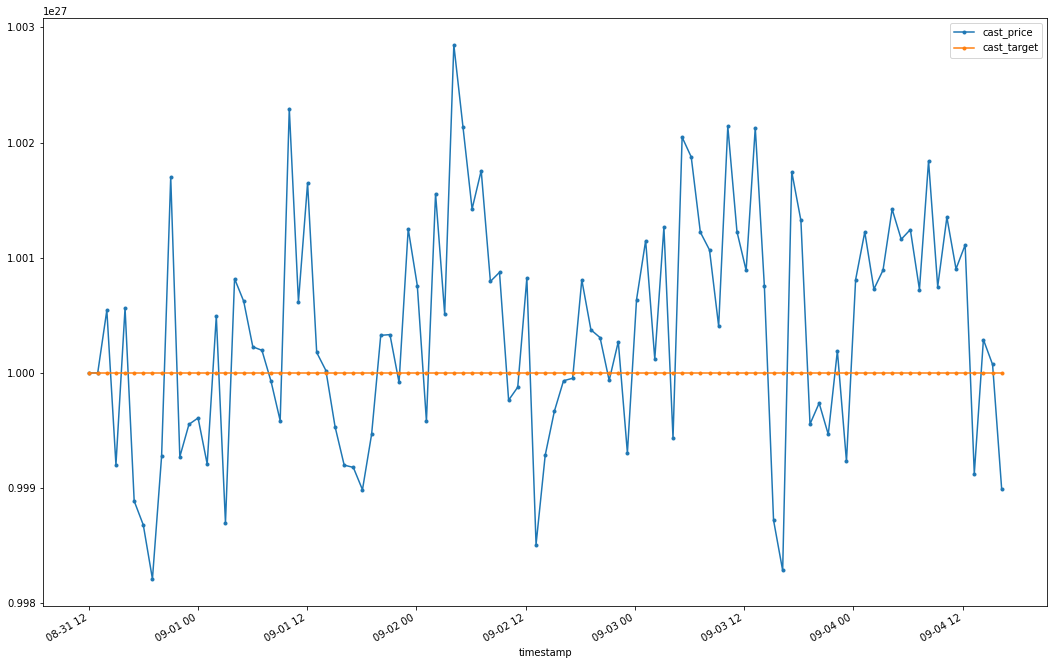

In [20]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['cast_price','cast_target'], marker='.', ax=plt.gca())

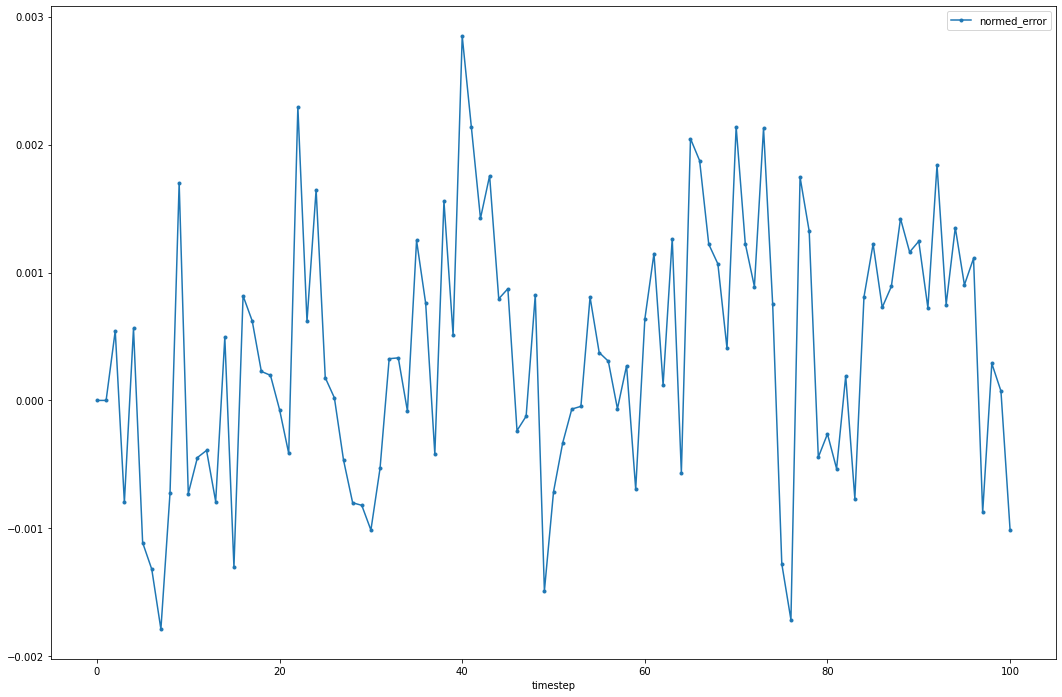

In [21]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestep', y='normed_error', marker='.', ax=plt.gca())


Text(0, 0.5, 'Observed Error in 1/RAY')

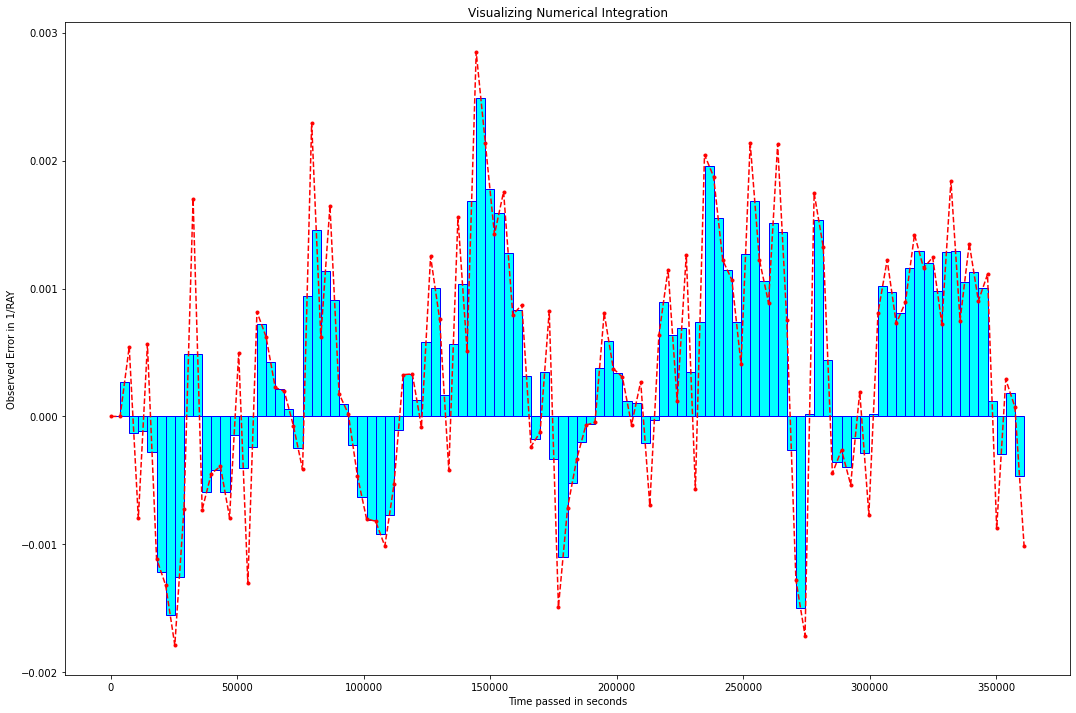

In [22]:
rdf['seconds'] = rdf.Dt.cumsum()


x=rdf.seconds.values
y=rdf.normed_error.values
h=rdf.normed_mean_error.values
w=rdf.Dt.values

plt.figure(figsize=(18, 12))
plt.plot(x,y , marker='.',linestyle='--', color='r')

ax = plt.gca()

for p in range(len(x)-1):
    ax.add_patch(
        Rectangle(
        (x[p], 0),
        w[p+1],
        h[p+1],
        edgecolor = 'blue',
        facecolor = 'cyan',
        fill=True
     ) )

plt.title('Visualizing Numerical Integration')
plt.xlabel('Time passed in seconds')
plt.ylabel('Observed Error in 1/RAY')


Text(0, 0.5, 'Observed Error in large integer form')

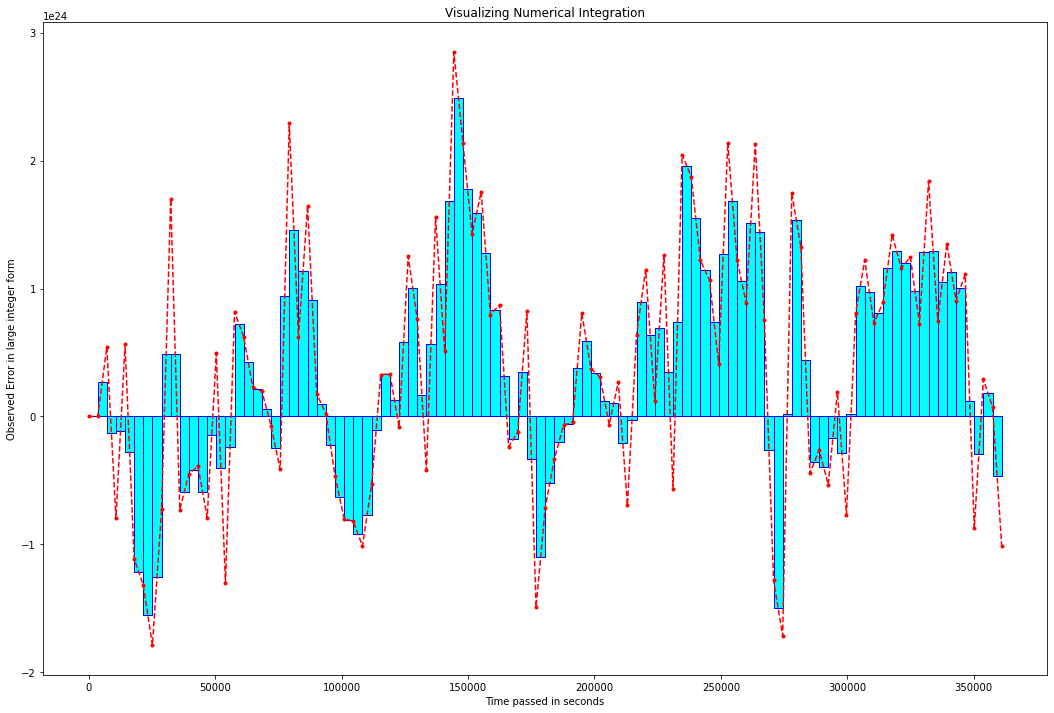

In [23]:
rdf['seconds'] = rdf.Dt.cumsum()


x=rdf.seconds.values
y=rdf.normed_error.apply(lambda x: float(x*RAY)).values
h=rdf.normed_mean_error.values
w=rdf.Dt.values

plt.figure(figsize=(18, 12))
plt.plot(x,y , marker='.',linestyle='--', color='r')

ax = plt.gca()

for p in range(len(x)-1):
    ax.add_patch(
        Rectangle(
        (x[p], 0),
        w[p+1],
        int(h[p+1]*RAY),
        edgecolor = 'blue',
        facecolor = 'cyan',
        fill=True
     ) )

plt.title('Visualizing Numerical Integration')
plt.xlabel('Time passed in seconds')
plt.ylabel('Observed Error in large integer form')